In [10]:
from pathlib import Path
import duckdb
import pandas as pd

data_root = Path("D:\\데이터\\건축데이터 건축허브 개방데이터")
path_DB = data_root / "건축물대장_2025년_02월.db"

건축허브에서 제공하는 건축물대장 데이터를 활용하여 분석

2025년 2월 이전 데이터는 위반건축물 등 일부 건축물이 빠져있는 문제가 있어 부득이 2025년 2월 말 데이터로 2024년 말 기준 건축물 현황을 집계

In [11]:
# Open a DuckDB connection
con = duckdb.connect(database=path_DB, read_only=True)

# print the list of tables in the database
tables = con.execute("SHOW TABLES").fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
    print()

# show heads of the tables
for table in tables:
    table_name = table[0]
    print(f"Head of {table_name}:")
    df = con.execute(f"SELECT * FROM {table_name} LIMIT 5").fetchdf()
    print(df)
    print()

Tables in the database:
기본개요

층별개요

표제부

Head of 기본개요:
  관리_건축물대장_PK 관리_상위_건축물대장_PK 대장_구분_코드 대장_구분_코드_명 대장_종류_코드 대장_종류_코드_명  \
0      100211           None        1         일반        1      총괄표제부   
1      100215           None        1         일반        1      총괄표제부   
2      100216           None        1         일반        1      총괄표제부   
3      100218           None        1         일반        1      총괄표제부   
4      100219           None        1         일반        1      총괄표제부   

                  대지_위치                  도로명_대지_위치  건물_명 시군구_코드  ...  \
0  서울특별시 종로구 관철동 12-1번지   서울특별시 종로구 종로14길 20 (관철동)  None  11110  ...   
1  서울특별시 종로구 청진동 21-1번지  서울특별시 종로구 종로5길 32-6 (청진동)  None  11110  ...   
2  서울특별시 종로구 중학동 16-2번지                       None  None  11110  ...   
3  서울특별시 종로구 중학동 24-1번지      서울특별시 종로구 율곡로 5 (중학동)  None  11110  ...   
4  서울특별시 종로구 중학동 35-1번지                       None  None  11110  ...   

  새주소_지상지하_코드 새주소_본_번 새주소_부_번 지역_코드 지구_코드 구역_코드 지역_코드_명  지구_코드_명 구역_코드_명  \
0  

In [12]:
# Create a list to store the table names and their record counts
table_counts = []

# Iterate through the tables and count the records
for table in tables:
    table_name = table[0]
    count = con.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
    table_counts.append({"Table Name": table_name, "Record Count": count})

# Convert the list to a DataFrame
record_counts_df = pd.DataFrame(table_counts)

# Display the DataFrame
display(record_counts_df)

,Table Name,Record Count
0,기본개요,27994157
1,층별개요,21048715
2,표제부,8027067


In [13]:
# Create a temporary view with the selected columns
표제부_필터링 = con.sql("""
    SELECT 
        "주_용도_코드",
        "주_용도_코드_명",
        "기타_용도"
    FROM 표제부
""")

In [14]:
# Display the first few rows
표제부_필터링_df = con.execute("SELECT * FROM 표제부_필터링 LIMIT 10000").fetchdf()
# Process the DataFrame
filtered_sampled_df = (
    표제부_필터링_df.drop_duplicates()
    .sort_values(by=["주_용도_코드"])
    .groupby("주_용도_코드")
    .filter(lambda x: len(x) >= 100)  # Drop groups with less rows
    .reset_index(drop=True)
    .groupby("주_용도_코드")
    .apply(lambda x: x.sample(n=10, replace=False, random_state=42))
    .reset_index(drop=True)
)

# Display the processed DataFrame
display(filtered_sampled_df)

# Save the processed DataFrame to a CSV file in the results directory
results_dir = Path("../results")
filtered_sampled_df.to_csv(
    results_dir / "표제부_용도_기재내용_예시.csv", index=False, encoding="utf-8-sig"
)

C:\Users\USER\AppData\Local\Temp\ipykernel_21788\2435543039.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=10, replace=False, random_state=42))


,주_용도_코드,주_용도_코드_명,기타_용도
0,01000,단독주택,"단독주택(다가구주택),제1종근린생활시설((소매점)"
1,01000,단독주택,다가구주택(14가구)
2,01000,단독주택,"공동주택(다세대), 근린생활시설"
3,01000,단독주택,단독주택(5가구)
4,01000,단독주택,"법당, 주택"
5,01000,단독주택,근린생활시설및 주택
6,01000,단독주택,단독주택(다가구주택 및 근생)
7,01000,단독주택,"근린생활시설, 공동주택(다세대주택)"
8,01000,단독주택,"주택, 변소및창고"
9,01000,단독주택,주택.근린생활시설


In [15]:
# Perform value count using SQL
value_counts_sql = con.sql("""
    SELECT 
        "주_용도_코드",
        "주_용도_코드_명",
        "기타_용도",
        COUNT(*) AS "Count"
    FROM 표제부_필터링
    GROUP BY "주_용도_코드", "주_용도_코드_명", "기타_용도"
    ORDER BY "Count" DESC
""")

# Fetch and display the result
value_counts_df = value_counts_sql.fetchdf()
display(value_counts_df.head(30))
# Save the top 30 rows to a CSV file
value_counts_df.head(30).to_csv(
    results_dir / "표제부_용도_기재내용_top30.csv", index=False, encoding="utf-8-sig"
)

,주_용도_코드,주_용도_코드_명,기타_용도,Count
0,01000,단독주택,단독주택,1722659
1,01000,단독주택,주택,1592478
2,04000,제2종근린생활시설,제2종근린생활시설,327131
3,17000,공장,공장,304174
4,18000,창고시설,창고시설,230618
5,03000,제1종근린생활시설,제1종근린생활시설,185441
6,21000,동물및식물관련시설,동.식물관련시설,158005
7,02000,공동주택,공동주택,112514
8,02000,공동주택,다세대주택,86467
9,03000,제1종근린생활시설,근린생활시설,81974


In [17]:
# Calculate the sum of counts grouped by 주_용도_코드
sum_by_code_sql = con.sql("""
    SELECT 
        "주_용도_코드",
        "주_용도_코드_명",
        SUM("Count") AS "Total Count"
    FROM value_counts_sql
    GROUP BY "주_용도_코드", "주_용도_코드_명"
    ORDER BY "Total Count" DESC
""")

# Fetch and display the result
sum_by_code_df = sum_by_code_sql.fetchdf().astype({"Total Count": "int"})
display(sum_by_code_df)

# Save the result to a CSV file
sum_by_code_df.to_csv(
    results_dir / "동_주_용도_코드별_합계.csv", index=False, encoding="utf-8-sig"
)

,주_용도_코드,주_용도_코드_명,Total Count
0,01000,단독주택,4344979
1,04000,제2종근린생활시설,719292
2,03000,제1종근린생활시설,595408
3,02000,공동주택,578529
4,21000,동물및식물관련시설,440924
...,...,...,...
119,15100,일반숙박시설,1
120,19001,주유소,1
121,1000,None,1
122,07100,소매시장,1


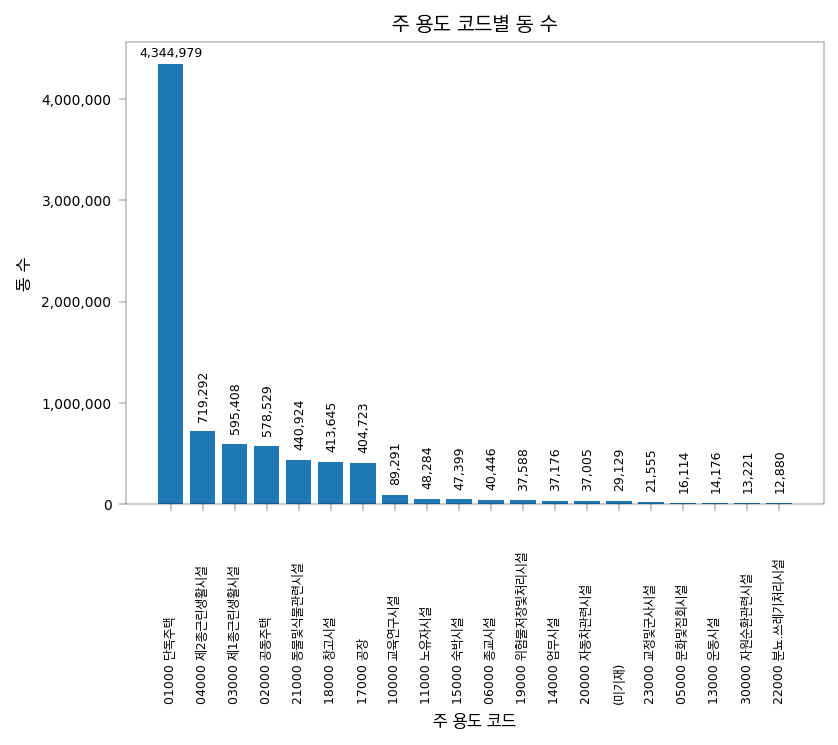

In [18]:
import matplotlib.pyplot as plt

# Apply the custom style
plt.style.use("./auri.mplstyle")

head_df = sum_by_code_df.head(20)

# Plot the bar chart
plt.bar(
    (head_df["주_용도_코드"] + " " + head_df["주_용도_코드_명"]).fillna("(미기재)"),
    head_df["Total Count"],
)
for i, value in enumerate(head_df["Total Count"]):
    if i in [0]:
        plt.text(
            i,
            value + 40000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            # rotation=45,
        )
    if i in range(1, 21):
        plt.text(
            i + 0.03,  # Move text slightly to the right
            value + 100000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            rotation=90,
        )
plt.xlabel("주 용도 코드")
plt.ylabel("동 수")
plt.title("주 용도 코드별 동 수")
plt.ticklabel_format(
    style="plain", axis="y"
)  # Use plain style for full numbers on y-axis
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)  # Format y-axis with commas
plt.xticks(rotation=90, ha="center", va="bottom", fontsize=6)
for lbl in plt.gca().get_xticklabels():
    lbl.set_y(-0.40)
# Save the plot to a file
plt.savefig(results_dir / "동_주_용도_코드별_동_수_막대그래프.png")
# Show the plot
plt.show()

In [19]:
value_counts_df

,주_용도_코드,주_용도_코드_명,기타_용도,Count
0,01000,단독주택,단독주택,1722659
1,01000,단독주택,주택,1592478
2,04000,제2종근린생활시설,제2종근린생활시설,327131
3,17000,공장,공장,304174
4,18000,창고시설,창고시설,230618
...,...,...,...,...
263414,01000,단독주택,주거시설 근린생활시설 위험물저장및처리시설,1
263415,14000,업무시설,"일반업무시설, 사무실",1
263416,04000,제2종근린생활시설,제2종근생((제조업)),1
263417,01000,단독주택,"주택, 부택",1


In [20]:
# Create a temporary view to split the '기타_용도' column into arrays using a regular expression
value_counts_split = con.sql("""
    SELECT 
        *,
        regexp_split_to_array(lower("기타_용도"), '[^\\p{L}\\d]+') AS "기타_용도_분리"
    FROM value_counts_sql
""")

# Fetch and display the result
value_counts_split.fetchdf()

,주_용도_코드,주_용도_코드_명,기타_용도,Count,기타_용도_분리
0,01000,단독주택,단독주택,1722659,[단독주택]
1,01000,단독주택,주택,1592478,[주택]
2,04000,제2종근린생활시설,제2종근린생활시설,327131,[제2종근린생활시설]
3,17000,공장,공장,304174,[공장]
4,18000,창고시설,창고시설,230618,[창고시설]
...,...,...,...,...,...
263414,21000,동물및식물관련시설,동물및식물과련시설(소독부스),1,"[동물및식물과련시설, 소독부스, ]"
263415,01000,단독주택,주택및수양관,1,[주택및수양관]
263416,05000,문화및집회시설,위락시설 외3,1,"[위락시설, 외3]"
263417,03000,제1종근린생활시설,"근린생활시설, 아동복지시설, 주택",1,"[근린생활시설, 아동복지시설, 주택]"


In [21]:
# Create a temporary view to split the '기타_용도' column into rows using a regular expression
value_counts_split_table = con.sql("""
    SELECT 
        *,
        regexp_split_to_table(lower("기타_용도"), '[^\\p{L}\\d]+') AS "기타_용도_분리"
    FROM value_counts_sql
""")

# Fetch and display the result
value_counts_split_table.fetchdf()

,주_용도_코드,주_용도_코드_명,기타_용도,Count,기타_용도_분리
0,01000,단독주택,단독주택,1722659,단독주택
1,01000,단독주택,주택,1592478,주택
2,04000,제2종근린생활시설,제2종근린생활시설,327131,제2종근린생활시설
3,17000,공장,공장,304174,공장
4,18000,창고시설,창고시설,230618,창고시설
...,...,...,...,...,...
838976,06000,종교시설,"요사체, 법당, 산신각, 종각, 창고",1,종각
838977,06000,종교시설,"요사체, 법당, 산신각, 종각, 창고",1,창고
838978,01000,단독주택,"소매점, 주택.사무소",1,소매점
838979,01000,단독주택,"소매점, 주택.사무소",1,주택


In [22]:
# Group by 주_용도_코드, 주_용도_코드_명, and 기타_용도_분리 and calculate the sum of Count
sum_by_words = con.sql("""
    SELECT 
        "기타_용도_분리",
        SUM("Count") AS "Total Count"
    FROM value_counts_split_table
    GROUP BY "기타_용도_분리"
    ORDER BY "Total Count" DESC
""")
# Drop rows where "기타_용도_분리" is empty
sum_by_words = sum_by_words.filter(
    "기타_용도_분리 IS NOT NULL AND 기타_용도_분리 != ''"
)
# Fetch and display the result
sum_by_words_df = sum_by_words.fetchdf().astype({"Total Count": "int"})
display(sum_by_words_df.head(30))

# Save the result to a CSV file
sum_by_words_df.to_csv(
    results_dir / "동_기타_용도_단어별_합계_중복포함.csv",
    index=False,
    encoding="utf-8-sig",
)

,기타_용도_분리,Total Count
0,단독주택,2114809
1,주택,2069361
2,근린생활시설,513863
3,제2종근린생활시설,504077
4,공장,362588
5,제1종근린생활시설,290552
6,창고시설,280232
7,창고,272363
8,공동주택,262082
9,식물관련시설,187056


In [23]:
value_counts_split_table.fetchdf()

,주_용도_코드,주_용도_코드_명,기타_용도,Count,기타_용도_분리
0,01000,단독주택,단독주택,1722659,단독주택
1,01000,단독주택,주택,1592478,주택
2,04000,제2종근린생활시설,제2종근린생활시설,327131,제2종근린생활시설
3,17000,공장,공장,304174,공장
4,18000,창고시설,창고시설,230618,창고시설
...,...,...,...,...,...
838976,04000,제2종근린생활시설,"점포,여관,주택",1,점포
838977,04000,제2종근린생활시설,"점포,여관,주택",1,여관
838978,04000,제2종근린생활시설,"점포,여관,주택",1,주택
838979,18000,창고시설,"주택, 창고축사",1,주택


In [24]:
# Select one distinct record for each 기타_용도_분리
distinct_record_sql = con.sql("""
    SELECT DISTINCT ON ("기타_용도_분리") 
        "기타_용도_분리", 
        "기타_용도",
        "주_용도_코드", 
        "주_용도_코드_명"
    FROM value_counts_split_table
    WHERE "기타_용도_분리" IS NOT NULL AND "기타_용도_분리" != ''
    ORDER BY "Count" DESC
""")

# Fetch and display the result
distinct_record_df = distinct_record_sql.fetchdf()
display(distinct_record_df)


,기타_용도_분리,기타_용도,주_용도_코드,주_용도_코드_명
0,단독주택,단독주택,01000,단독주택
1,주택,주택,01000,단독주택
2,제2종근린생활시설,제2종근린생활시설,04000,제2종근린생활시설
3,공장,공장,17000,공장
4,창고시설,창고시설,18000,창고시설
...,...,...,...,...
46805,토산품가내공업센타,토산품가내공업센타,17000,공장
46806,공장및복지시설,공장및복지시설,17000,공장
46807,제1종근린생활시설및제2종근린생활시설및단독주택,제1종근린생활시설및제2종근린생활시설및단독주택,01000,단독주택
46808,카트실,운동시설(기계실/카트실/락카/식당/로비),13000,운동시설


In [26]:
# top 30 from grouped_sum
top_words_df = sum_by_words_df.head(30)

# join it with distinct_record_sql in sql
usage_sample_sql = con.sql("""
    SELECT 
        t."기타_용도_분리",
        t."Total Count",
        d."기타_용도",
        d."주_용도_코드",
        d."주_용도_코드_명"
    FROM top_words_df t
    JOIN distinct_record_sql d 
    ON t."기타_용도_분리" = d."기타_용도_분리"
    ORDER BY t."Total Count" DESC
""")
# Fetch and display the result
usage_sample_df = usage_sample_sql.fetchdf()
display(usage_sample_df)

# Save the result to a CSV file
usage_sample_df.to_csv(
    results_dir / "동_기타_용도_단어별_합계_중복포함_예시.csv",
    index=False,
    encoding="utf-8-sig",
)

,기타_용도_분리,Total Count,기타_용도,주_용도_코드,주_용도_코드_명
0,단독주택,2114809,단독주택,01000,단독주택
1,주택,2069361,주택,01000,단독주택
2,근린생활시설,513863,근린생활시설,03000,제1종근린생활시설
3,제2종근린생활시설,504077,제2종근린생활시설,04000,제2종근린생활시설
4,공장,362588,공장,17000,공장
5,제1종근린생활시설,290552,제1종근린생활시설,03000,제1종근린생활시설
6,창고시설,280232,창고시설,18000,창고시설
7,창고,272363,창고,18000,창고시설
8,공동주택,262082,공동주택,02000,공동주택
9,식물관련시설,187056,동.식물관련시설,21000,동물및식물관련시설


In [27]:
value_counts_split_table

┌──────────────┬────────────────────┬────────────────────────────────────┬─────────┬───────────────────┐
│ 주_용도_코드 │  주_용도_코드_명   │             기타_용도              │  Count  │  기타_용도_분리   │
│   varchar    │      varchar       │              varchar               │  int64  │      varchar      │
├──────────────┼────────────────────┼────────────────────────────────────┼─────────┼───────────────────┤
│ 01000        │ 단독주택           │ 단독주택                           │ 1722659 │ 단독주택          │
│ 01000        │ 단독주택           │ 주택                               │ 1592478 │ 주택              │
│ 04000        │ 제2종근린생활시설  │ 제2종근린생활시설                  │  327131 │ 제2종근린생활시설 │
│ 17000        │ 공장               │ 공장                               │  304174 │ 공장              │
│ 18000        │ 창고시설           │ 창고시설                           │  230618 │ 창고시설          │
│ 03000        │ 제1종근린생활시설  │ 제1종근린생활시설                  │  185441 │ 제1종근린생활시설 │
│ 21000        │ 동물및식물관련시설 │ 동.식물관련시설                    

In [28]:
# Create a temporary view grouped_df by grouping and summing the counts
sum_by_code_words_sql = con.sql("""
    SELECT 
        "주_용도_코드",
        FIRST("주_용도_코드_명") AS "주_용도_코드_명",
        "기타_용도_분리",
        SUM("Count") AS "Total Count"
    FROM value_counts_split_table
    WHERE "기타_용도_분리" IS NOT NULL AND "기타_용도_분리" != ''
    GROUP BY "주_용도_코드", "기타_용도_분리"
    ORDER BY "Total Count" DESC;
""")

# Fetch and display the result
sum_by_code_words_df = sum_by_code_words_sql.fetchdf().astype({"Total Count": "int"})
display(sum_by_code_words_df)

# Save the result to a CSV file
sum_by_code_words_df.to_csv(
    results_dir / "동_주_용도_코드별_기타_용도_단어별_합계.csv",
    index=False,
    encoding="utf-8-sig",
)

,주_용도_코드,주_용도_코드_명,기타_용도_분리,Total Count
0,01000,단독주택,단독주택,2013416
1,01000,단독주택,주택,1905896
2,04000,제2종근린생활시설,제2종근린생활시설,410247
3,17000,공장,공장,353329
4,02000,공동주택,공동주택,257505
...,...,...,...,...
75501,21000,동물및식물관련시설,원예용,1
75502,10000,교육연구시설,라커실,1
75503,04000,제2종근린생활시설,지하1층,1
75504,17000,공장,오니침전조,1


In [31]:
# Pivot the data
pivot_df = sum_by_code_words_df.pivot_table(
    index="주_용도_코드",
    columns="기타_용도_분리",
    values="Total Count",
    aggfunc="sum",
    fill_value=0,
)
# Limit the pivot table to the top 30 rows and columns based on Total Count
top_columns = (
    sum_by_code_words_df.groupby("기타_용도_분리")["Total Count"]
    .sum()
    .nlargest(10)
    .index
)

pivot_df = pivot_df.loc[:, top_columns]

# Sort the pivot table by the index
pivot_df = pivot_df.sort_index()
pivot_df = pivot_df.loc[
    :,
    pivot_df.sum(axis=0).sort_values(ascending=False).index,
]

# select rows with sum > 1000
pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > 1000]

# Add the 주_용도_코드_명 as a label column
pivot_df.insert(
    0,
    "주_용도_코드_명",
    sum_by_code_words_df.drop_duplicates("주_용도_코드").set_index("주_용도_코드")[
        "주_용도_코드_명"
    ],
)

# Display the pivot table
display(pivot_df)

# Save the pivot table to a CSV file
pivot_df.to_csv(
    results_dir / "동_주_용도_코드별_상위_단어별_빈도_pivot.csv",
    index=True,
    encoding="utf-8-sig",
)

기타_용도_분리,주_용도_코드_명,단독주택,주택,근린생활시설,제2종근린생활시설,공장,제1종근린생활시설,창고시설,창고,공동주택,식물관련시설
주_용도_코드,,,,,,,,,,,
01000,단독주택,2013416,1905896,149834,59280,1812,37238,18215,123186,1552,1035
02000,공동주택,381,7592,17905,6709,197,4613,119,848,257505,2
03000,제1종근린생활시설,33428,78241,161711,14378,628,229181,3758,7722,519,37
04000,제2종근린생활시설,46781,44144,150633,410247,2671,11261,4150,7960,451,68
05000,문화및집회시설,153,101,457,266,13,250,38,141,5,9
06000,종교시설,622,1080,789,990,4,221,44,520,4,1
07000,판매시설,84,146,1163,509,18,177,112,153,78,0
09000,의료시설,53,114,568,224,1,477,17,129,4,0
10000,교육연구시설,483,513,2004,750,146,621,82,2014,61,5


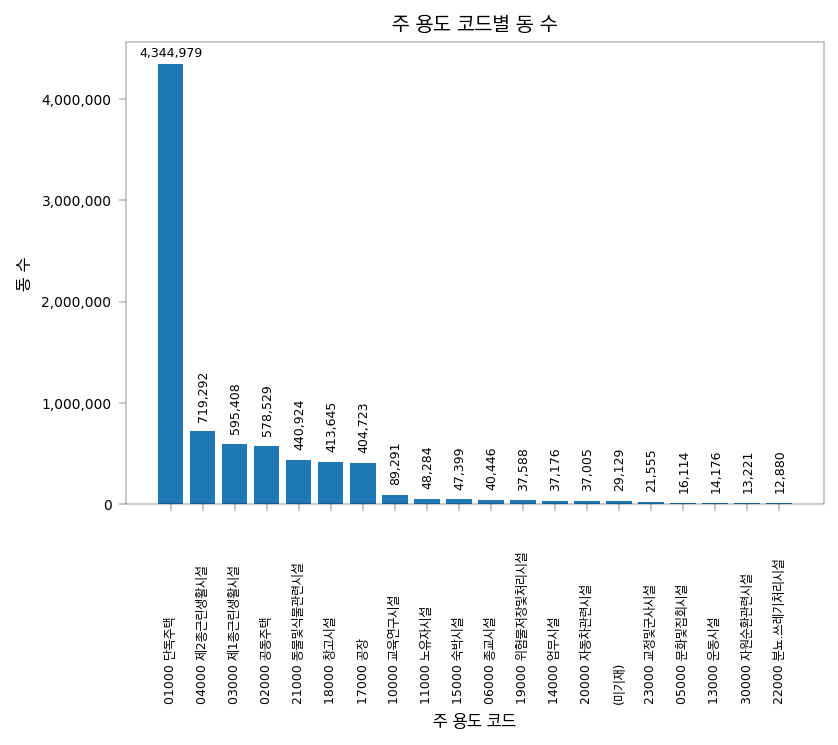

In [32]:
import matplotlib.pyplot as plt

# Apply the custom style
plt.style.use("./auri.mplstyle")

head_df = sum_by_code_df.head(20)

# Plot the bar chart
plt.bar(
    (head_df["주_용도_코드"] + " " + head_df["주_용도_코드_명"]).fillna("(미기재)"),
    head_df["Total Count"],
)
for i, value in enumerate(head_df["Total Count"]):
    if i in [0]:
        plt.text(
            i,
            value + 40000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            # rotation=45,
        )
    if i in range(1, 21):
        plt.text(
            i + 0.03,  # Move text slightly to the right
            value + 100000,  # Move text slightly up
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=6,
            rotation=90,
        )
plt.xlabel("주 용도 코드")
plt.ylabel("동 수")
plt.title("주 용도 코드별 동 수")
plt.ticklabel_format(
    style="plain", axis="y"
)  # Use plain style for full numbers on y-axis
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)  # Format y-axis with commas
plt.xticks(rotation=90, ha="center", va="bottom", fontsize=6)
for lbl in plt.gca().get_xticklabels():
    lbl.set_y(-0.40)
# Save the plot to a file
plt.savefig(results_dir / "동_주_용도_코드별_동_수_막대그래프.png")
# Show the plot
plt.show()